In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [24]:
# Fetching Historical Stock Data
def fetch_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    data['Ticker'] = ticker
    return data

start_date = "2013-01-01"
end_date = "2024-12-01"
adbe_data = fetch_data("ADBE", start_date, end_date)
msft_data = fetch_data("MSFT", start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


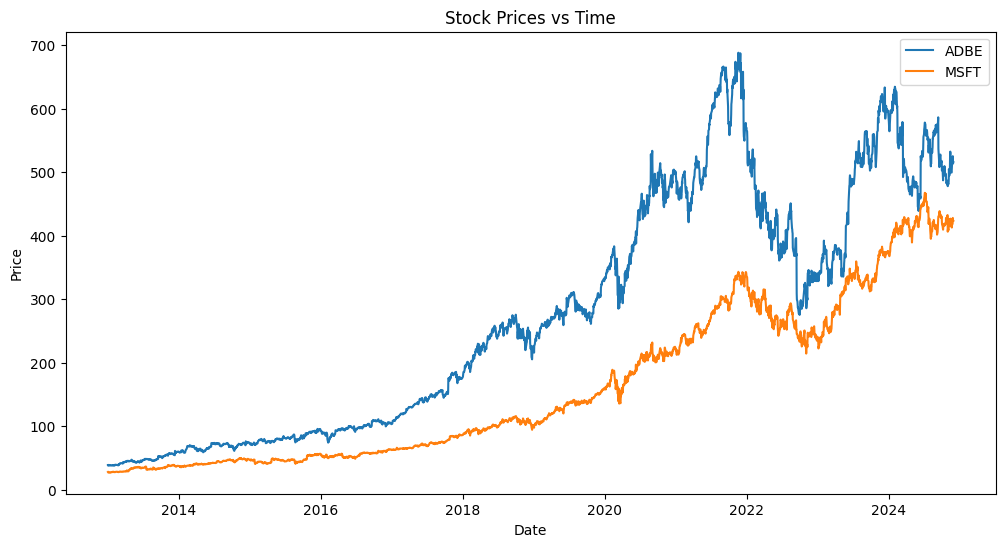

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(adbe_data.Close, label='ADBE')
plt.plot(msft_data.Close, label='MSFT')
plt.title('Stock Prices vs Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
# Merging two datasets on date
data = pd.merge(adbe_data[['Close']], msft_data[['Close']], left_index=True, right_index=True, suffixes=("_ADBE", "_MSFT"))
data['Price_Ratio'] = data['Close_ADBE'] / data['Close_MSFT']
data.head()

,Close_ADBE,Close_MSFT,Price_Ratio
Date,,,
2013-01-02,38.340000,27.620001,1.388125
2013-01-03,37.750000,27.250000,1.385321
2013-01-04,38.130001,26.740000,1.425954
2013-01-07,37.939999,26.690001,1.421506
2013-01-08,38.139999,26.549999,1.436535


In [27]:
# Feature Engineering
data['MA_5'] = data['Price_Ratio'].rolling(5).mean()
data['MA_20'] = data['Price_Ratio'].rolling(20).mean()
data['MA_60'] = data['Price_Ratio'].rolling(60).mean()
data['ROC'] = data['Price_Ratio'].pct_change() * 100
data['Volatility'] = data['Price_Ratio'].rolling(20).std()
data['Lag_1'] = data['Price_Ratio'].shift(1)
data.dropna(inplace=True)

In [40]:
# Train Machine Learning Model
features = ['MA_5', 'MA_20', 'MA_60', 'ROC', 'Volatility', 'Lag_1']
X = data[features]
y = data['Price_Ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = False)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

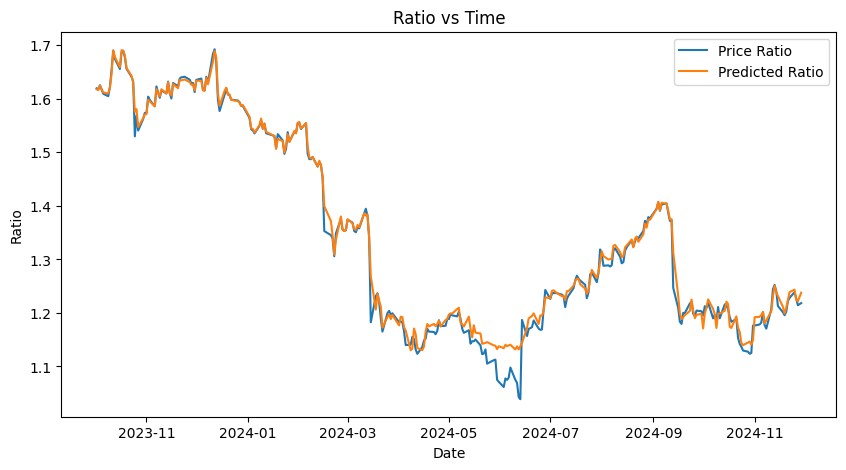

In [41]:
# Predict test sets
data.loc[X_test.index, 'Predicted_Ratio'] = model.predict(X_test)
plt.figure(figsize=(10, 5))
plt.plot(data["Price_Ratio"][X_test.index], label='Price Ratio')
plt.plot(data["Predicted_Ratio"][X_test.index], label='Predicted Ratio')
plt.title('Ratio vs Time')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()
plt.show()

In [51]:
# Trading Signals
data['Signal'] = np.where(data['Predicted_Ratio'] > data['Price_Ratio'], 'Buy', 
                          np.where(data['Predicted_Ratio'] < data['Price_Ratio'], 'Sell', 'No Order'))

In [52]:
initial_capital = 1000
capital = initial_capital
positions = {'ADBE': 0, 'MSFT': 0}

pnl = []
for i in range(len(X_train), len(data)):
    signal = data['Signal'].iloc[i]
    adbe_price = data['Close_ADBE'].iloc[i]
    msft_price = data['Close_MSFT'].iloc[i]

    if signal == 'Buy':
        positions['ADBE'] += 1
        positions['MSFT'] -= 1
        capital -= adbe_price - msft_price
    elif signal == 'Sell':
        positions['ADBE'] -= 1
        positions['MSFT'] += 1
        capital += adbe_price - msft_price

    current_pnl = capital + positions['ADBE'] * adbe_price + positions['MSFT'] * msft_price - initial_capital
    pnl.append(current_pnl)

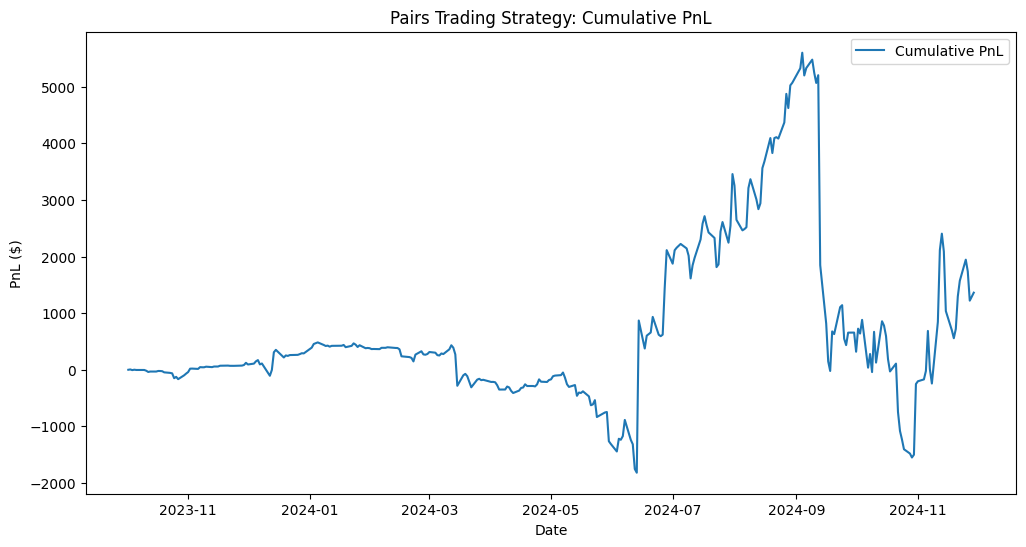

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[len(X_train):], pnl, label='Cumulative PnL')
plt.title('Pairs Trading Strategy: Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('PnL ($)')
plt.legend()
plt.show()